In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
metric = "rmse"
mmgt = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/v0/10percent/mmgt/inference-validation/{metric}.nested-lam.nc", decode_timedelta=True)
hrrr = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/v0/baselines/hrrr-forecasts-vs-hrrr-analysis/{metric}.lam.nc", decode_timedelta=True)
gfs = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/v0/baselines/gfs-forecasts-vs-hrrr-analysis/{metric}.lam.nc", decode_timedelta=True)

In [4]:
mmgt = mmgt.sel(fhr=slice(48))

In [5]:
nice_names = {
    "sp": "Surface Pressure",
    "u10": "10m Zonal Wind",
    "v10": "10m Meridional Wind",
    "t2m": "2m Temperature",
    "sh2": "2m Specific Humidity",
    "gh": "Geopotential Height",
    "u": "Zonal Wind",
    "v": "Meridional Wind",
    "w": "Vertical Velocity",
    "t": "Temperature",
    "q": "Specific Humidity",
}

In [6]:
#surface_vars = ["sp", "u10", "v10", "t2m", "sh2"]
surface_vars = ["t2m", "u10"]

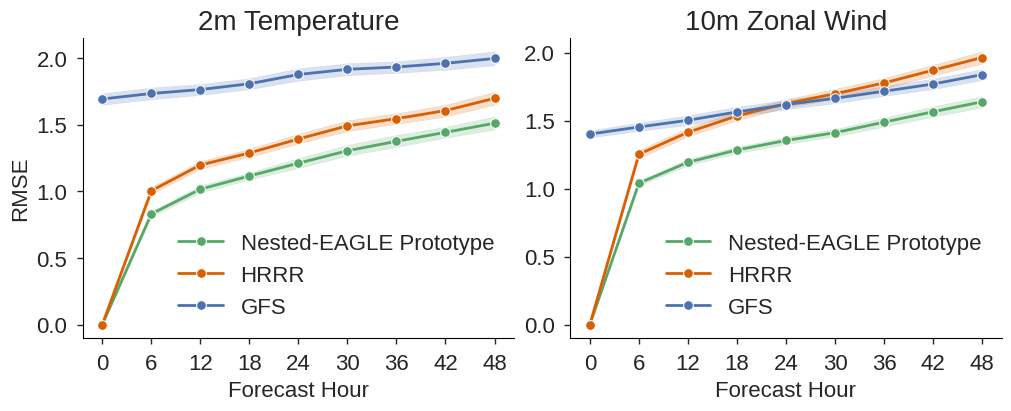

In [15]:
ncols = len(surface_vars)
fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4), constrained_layout=True)

kw = {
    "marker": "o",
}

for varname, ax in zip(surface_vars, axs):
    for xds, label in zip(
        [mmgt, hrrr, gfs],
        ["Nested-EAGLE Prototype", "HRRR", "GFS"],
    ):
        df = xds[varname].to_dataframe().reset_index()
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            **kw,
        )
    ax.set(
        ylabel="RMSE" if ax.get_subplotspec().is_first_col() else "",
        xlabel="Forecast Hour",
        title=nice_names[varname] if ax.get_subplotspec().is_first_row() else "",
        xticks=mmgt.fhr.values,
    )
    ax.legend(frameon=False)
fig.savefig(f"figures/surface_rmse_2fields.jpeg", dpi=300, bbox_inches="tight")

In [16]:
level_vars = ["gh", "u", "t"]

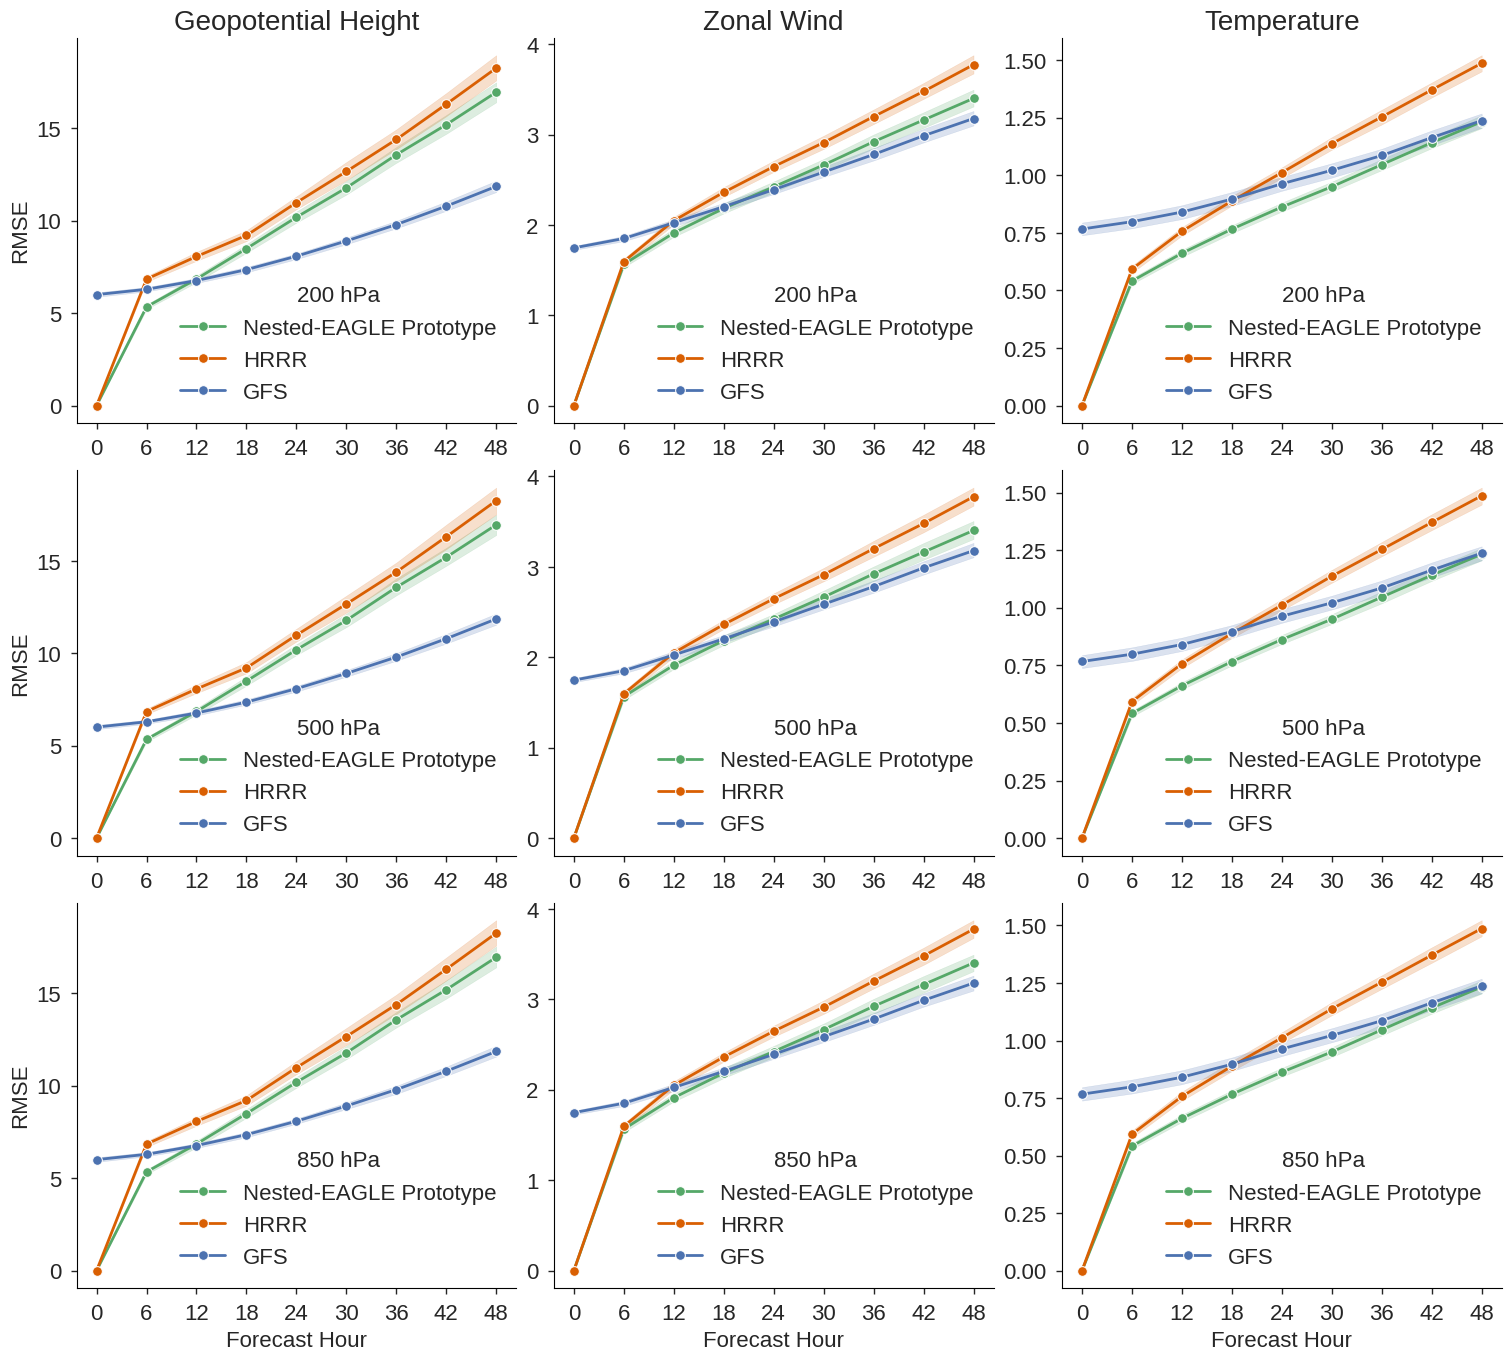

In [17]:
ncols = len(level_vars)
nrows = len(hrrr.level)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows), constrained_layout=True)


for level, axr in zip(hrrr.level.values, axs):
    for varname, ax in zip(level_vars, axr):
        for xds, label in zip(
            [mmgt, hrrr, gfs],
            ["Nested-EAGLE Prototype", "HRRR", "GFS"],
        ):
            df = xds[varname].to_dataframe().reset_index()
            sns.lineplot(
                data=df,
                x="fhr",
                y=varname,
                ax=ax,
                label=label,
                **kw,
            )
        ax.set(
            ylabel="RMSE" if ax.get_subplotspec().is_first_col() else "",
            xlabel="Forecast Hour" if ax.get_subplotspec().is_last_row() else "",
            title=nice_names[varname] if ax.get_subplotspec().is_first_row() else "",
            xticks=mmgt.fhr.values,
        )
        ax.legend(title=f"{level} hPa", frameon=False, loc="lower right")
fig.savefig(f"figures/plevel_rmse_3fields.jpeg", dpi=300, bbox_inches="tight")